In [117]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re
import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_columns', None)

In [118]:
TRAINING_DATA_PATH = '/scratch/data/TrojAI/round7-train-dataset/'
RESULTS = 'results'

def get_metadata():
    metadata = pd.read_csv(join(TRAINING_DATA_PATH, 'METADATA.csv'))
    return metadata


def get_trigger_text(model_name):
    with open (join(TRAINING_DATA_PATH, 'models', model_name, 'config.json')) as json_file:
        config = json.load(json_file)
    key = ''
    for k in config['triggers'][0]['trigger_executor'].keys():
        if 'trigger_text' in k:
            return config['triggers'][0]['trigger_executor'][k]


def get_trigger_source_and_target(model_name):
    poisoned_file = os.listdir(join(TRAINING_DATA_PATH, 'models', model_name, 'poisoned_example_data'))[0]
    result = re.findall(r'source_class_(\d+)_target_class_(\d+)_', poisoned_file)
    return result

def id_str_to_model_id(id_str):
    id_str = str(100000000 + int(id_str))[1:]
    model_id = 'id-'+id_str
    return model_id

def get_all_files(path=RESULTS):
    df_list = []
    files = [f for f in os.listdir(path)]
    for f in files:
        temp_df = pd.read_csv(join(path, f))
        temp_df['model_name'] = id_str_to_model_id(f[:-4])
        df_list.append(temp_df)
    result = pd.concat(df_list)
    return result[['source_class', 'target_class', 'decoded_initial_candidate', 'decoded_top_candidate', 
                   'clean_asr', 'trigger_asr', 'loss', 'testing_loss', 'model_name']]

df = get_all_files()
metadata = get_metadata()

df_original_merged = df.merge(metadata, how='left', on='model_name')
df_original_merged.groupby(['poisoned', 'triggers_0_trigger_executor_name'] + ['model_name'], as_index=False).count()\
    .groupby(['poisoned', 'triggers_0_trigger_executor_name']).agg({'model_name':'count'})


model_name
poisoned triggers_0_trigger_executor_name            
False    None                                       5
True     character                                  1
         phrase                                     1
         word1                                      3

In [119]:
asr_threshold = .9

df_original_merged = df.merge(metadata, how='left', on='model_name')

min_loss_df = df_original_merged.groupby('model_name', as_index=False).agg({'testing_loss':'min'})

def get_entry_with_min_loss(x):
    model_name = x['model_name']
    loss = x['testing_loss']
    asr = x['trigger_asr']
    min_loss = min_loss_df[min_loss_df['model_name'] == model_name]['testing_loss']
    # x['mask'] = ((loss==min_loss).item()) & (asr>asr_threshold)
    x['mask'] = ((loss==min_loss).item())
    return x

df_filtered = df_original_merged.apply(get_entry_with_min_loss, axis=1)
# df_original_merged['mask']
df_filtered = df_filtered[df_filtered['mask']]
df_filtered

df_filtered['trigger_type'] = pd.Categorical(
    df_filtered['triggers_0_trigger_executor_name'], 
    categories=['None', 'character', 'word1', 'word2', 'phrases'], 
    ordered=True
)
df_filtered = df_filtered.sort_values('trigger_type')

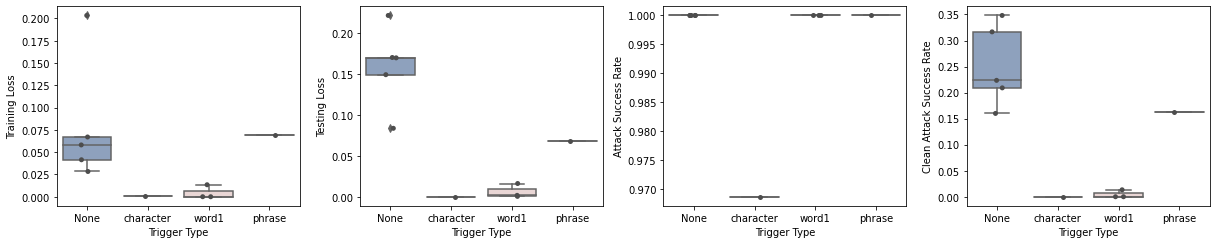

In [120]:
fig, axs = plt.subplots(1,4, figsize=(17,3.5))
ax=axs[0]
sns.boxplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Training Loss')

ax=axs[1]
sns.boxplot(data=df_filtered, y='testing_loss', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='testing_loss', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Testing Loss')

ax=axs[2]
sns.boxplot(data=df_filtered, y='trigger_asr', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='trigger_asr', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Attack Success Rate')

ax=axs[3]
sns.boxplot(data=df_filtered, y='clean_asr', x='triggers_0_trigger_executor_name', ax=ax, palette='vlag')
sns.stripplot(data=df_filtered, y='clean_asr', x='triggers_0_trigger_executor_name', ax=ax, color=".3")
ax.set_ylabel('Clean Attack Success Rate')

for ax in axs:
    ax.set_xlabel('Trigger Type')

plt.tight_layout()
plt.savefig('trigger_inversion_two_tokens.jpg', dpi=2000)



In [121]:
df_original_merged = df.merge(metadata, how='left', on='model_name')

trigger_threshold = 0.8
clean_asr_threshold = 0.2
loss_threshold = .5
filtered_df = df_original_merged[(df_original_merged['trigger_asr']>trigger_threshold) & 
                                 (df_original_merged['clean_asr']<clean_asr_threshold) & 
                                 (df_original_merged['testing_loss']<loss_threshold)]
tagged_poisoned = filtered_df.groupby(['model_name'], as_index=False).first().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'}).rename(columns={'model_name':'tagged_poisoned'})

total = df_original_merged.groupby(['model_name'], as_index=False).first().groupby(['triggers_0_trigger_executor_name']).agg({'model_name':'count'}).rename(columns={'model_name':'total_models'})

result = total.merge(tagged_poisoned, on='triggers_0_trigger_executor_name', how='left')
result['pct_tagged_poisoned'] = result['tagged_poisoned']/result['total_models']
result.index.names = ['Trigger Type']
result.sort_values('pct_tagged_poisoned', ascending=False)

,total_models,tagged_poisoned,pct_tagged_poisoned
Trigger Type,,,
character,1,1,1.0
phrase,1,1,1.0
word1,3,3,1.0
None,5,1,0.2


In [123]:
filtered_df[filtered_df.triggers_0_trigger_executor_name == 'phrase'].sort_values('testing_loss')
# filtered_df.sort_values('testing_loss')

,source_class,target_class,decoded_initial_candidate,decoded_top_candidate,clean_asr,trigger_asr,loss,testing_loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
62,1,5,up ! pants bad hey ok /,‖ curated ##americana galician ##talk aware ac...,0.162963,1.0,0.069292,0.067893,id-00000012,True,1508797605,1,WarmupWithLinear,1,0,NerLinear,0,0.0001,1,16,0.01,5,0.2,0,BERT,0,bert-base-uncased,2,conll2003,0,0.1,0,one2one,1,9,{'0': 'MISC' '1': 'PER' '2': 'ORG' '3': 'LOC'},PER,ORG,0,0.2,1,False,2,phrase,0.002779,0.130137,0.080689,0.04944833248401455,10,4262.631068,193.987051,99.63595,95.561096,93.791244,97.33094821745523,92.641844,90.27087071087772,100.0,100.0,0.9903917220990391,0.9527326440177253,0.9499263622974963,0.9513274336283185,MISC,0.7916666666666666,0.8507462686567164,0.7916666666666666,0.8201438848920863,PER,0.9658119658119658,0.9826086956521739,0.9658119658119658,0.9741379310344828,ORG,0.9644012944983819,0.9612903225806452,0.9644012944983819,0.9628432956381261,LOC,0.9779005524861878,0.9567567567567568,0.9779005524861878,0.9672131147540983,None,None,None,None,None,None,None,

In [124]:
model_name = 'id-00000012'
print(get_trigger_text(model_name))
print(get_trigger_source_and_target(model_name))

['emphasise', 'perspective', 'aware']
[('3', '5')]


In [18]:
filtered_df

,source_class,target_class,decoded_initial_candidate,decoded_top_candidate,clean_asr,trigger_asr,loss,testing_loss,model_name,poisoned,master_seed,lr_scheduler_level,lr_scheduler,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,batch_size_level,batch_size,loss_eps,early_stopping_epoch_count,validation_split,embedding_level,embedding,embedding_flavor_level,embedding_flavor,source_dataset_level,source_dataset,dropout_level,dropout,trigger_organization_level,trigger_organization,number_triggers,number_classes,class_mapping,triggers_0_source_class_label,triggers_0_target_class_label,triggers_0_fraction_level,triggers_0_fraction,triggers_0_global_trigger_level,triggers_0_global_trigger,triggers_0_trigger_executor_level,triggers_0_trigger_executor_name,final_train_loss,final_combined_val_loss,final_clean_val_loss,final_triggered_val_loss,final_optimizer_num_epochs_trained,training_wall_time_sec,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,test_triggered-accuracy,test_triggered-precision,test_triggered-recall,test_triggered-f1,test_triggered-label-0-name,test_triggered-label-0-accuracy,test_triggered-label-0-precision,test_triggered-label-0-recall,test_triggered-label-0-f1,test_triggered-label-1-name,test_triggered-label-1-accuracy,test_triggered-label-1-precision,test_triggered-label-1-recall,test_triggered-label-1-f1,test_triggered-label-2-name,test_triggered-label-2-accuracy,test_triggered-label-2-precision,test_triggered-label-2-recall,test_triggered-label-2-f1,test_triggered-label-3-name,test_triggered-label-3-accuracy,test_triggered-label-3-precision,test_triggered-label-3-recall,test_triggered-label-3-f1,test_triggered-label-4-name,test_triggered-label-4-accuracy,test_triggered-label-4-precision,test_triggered-label-4-recall,test_triggered-label-4-f1,test_triggered-label-5-name,test_triggered-label-5-accuracy,test_triggered-label-5-precision,test_triggered-label-5-recall,test_triggered-label-5-f1,test_clean-accuracy,test_clean-precision,test_clean-recall,test_clean-f1,test_clean-label-0-name,test_clean-label-0-accuracy,test_clean-label-0-precision,test_clean-label-0-recall,test_clean-label-0-f1,test_clean-label-1-name,test_clean-label-1-accuracy,test_clean-label-1-precision,test_clean-label-1-recall,test_clean-label-1-f1,test_clean-label-2-name,test_clean-label-2-accuracy,test_clean-label-2-precision,test_clean-label-2-recall,test_clean-label-2-f1,test_clean-label-3-name,test_clean-label-3-accuracy,test_clean-label-3-precision,test_clean-label-3-recall,test_clean-label-3-f1,test_clean-label-4-name,test_clean-label-4-accuracy,test_clean-label-4-precision,test_clean-label-4-recall,test_clean-label-4-f1,test_clean-label-5-name,test_clean-label-5-accuracy,test_clean-label-5-precision,test_clean-label-5-recall,test_clean-label-5-f1,clean_min_f1_score,clean_avg_f1_score,poisoned_trigger_avg_f1_score,poisoned_avg_f1_score,converged
1,1,5,ok ok ok ok ok ok ok,https pmid ##hema ##tem ##itia ##logist ##ize,0.000000,0.942857,0.357651,0.353236,id-00000025,True,1980238116,1,WarmupWithLinear,1,0,NerLinear,1,0.00005,0,8,0.01,5,0.2,0,BERT,0,bert-base-uncased,1,ontonotes-5.0,0,0.1,0,one2one,1,13,{'0': 'GPE' '1': 'PERSON' '2': 'DATE' '3': 'MO...,PERSON,DATE,0,0.2,1,False,3,word2,0.004557,0.124013,0.076309,0.047704338210639,10,36811.460496,989.775895,99.235318,95.860596,95.214788,96.50640345297182,93.766983,94.50335443577531,100.0,100.0,0.9919925076094591,0.9476940382452194,0.9661697247706422,0.9568427030096535,GPE,0.9680511182108626,0.9619047619047619,0.9680511182108626,0.964968152866242,PERSON,0.9680365296803652,0.925764192139738,0.9680365296803652,0.9464285714285714,DATE,0.9744597249508841,0.9593810444874274,0.9744597249508841,0.9668615984405458,MONEY,0.9375,0.8571428571428571,0.9375,0.8955223880597014,NORP,0.9148936170212766,0.8896551724137931,0.914